# Trabalho Computacional 01: TÓPICOS ESPECIAIS EM COMPUTAÇÃO APLICADA: LABORATÓRIO DE INTELIGÊNCIA ARTIFICIAL

**Tema:** Núcleo de Detecção de Anomalias para Sistema de Transporte de Motores

**Dupla:**

  * João Pedro Vidal Gomes de Souza (realizado em parceria com alunos da disciplina teórica de Introdução à Inteligência Artificial Álvaro Matoso e Vitor Moura)

**Link do Repositório GitHub:** [Inserir Link do GitHub aqui]

-----


## 1\. Problema e Recorte Escolhido

Conforme o requisito do `Trabalho_01.pdf`, este projeto parte do problema definido no HackatOhm: o "Plano de Trabalho Mestre para o Desenvolvimento de Sistema Integrado de Transporte de Motores Elétricos" (`Skid.pdf`).

  * **Problema Geral:** O `Skid.pdf` detalha um plano para transportar motores de grande porte, com foco em mitigar riscos dinâmicos como o "falso brinelamento" (causado por vibração) e "brinelling verdadeiro" (causado por choques). A Seção 8 propõe um sistema de monitoramento com um "Agente de IA Integrado" para analisar dados de sensores (acelerômetros) e gerar diagnósticos .

  * **Recorte Escolhido :** Este trabalho foca no **"núcleo técnico"** da detecção de anomalias (Seção 8.2 do `Skid.pdf`). Não implementaremos o pipeline de dados em nuvem (Google Cloud, Vertex AI)ou os cálculos físicos complexos (Seção 8.3).

  * **Objetivo do Núcleo:** Criar e validar um "pipeline mínimo viável" que consiga **distinguir "Choques Transientes Severos" de uma vibração de transporte normal** em um conjunto de dados de exemplo.

-----


## 2\. Dados e Licença

O sistema real proposto no `Skid.pdf` utilizaria dados de acelerômetros de alta fidelidade. Para este trabalho, que exige "amostra pequena com licença clara", optamos por **gerar dados sintéticos (simulados)**.

Isso nos dá controle total, rótulos perfeitos para validação e evita problemas de licença.

  * **Vibração Normal:** Simulada como uma onda senoidal de baixa amplitude, representando a vibração da estrada.
  * **Anomalias (Choques):** Simuladas como picos de alta amplitude e curta duração, injetados aleatoriamente no sinal, representando "buracos na estrada" ou "impactos".
  * **Licença:** Os dados são gerados por este script e são de domínio público.

-----


Dados gerados com 10 anomalias (choques).
   time    signal  true_label
0     0  0.049671         0.0
1     1  0.036090         0.0
2     2  0.164104         0.0
3     3  0.300063         0.0
4     4  0.171294         0.0


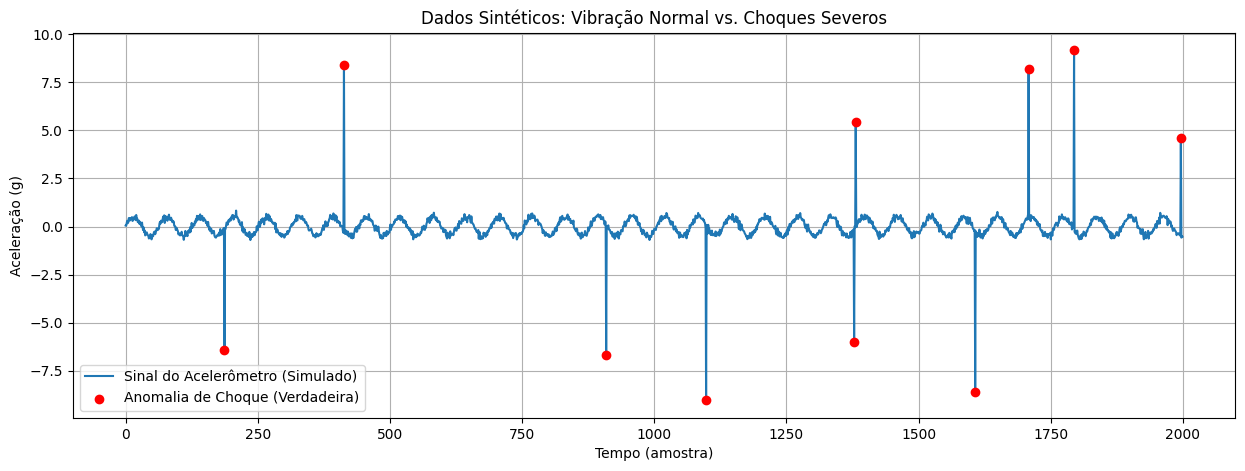

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# --- 1. Geração de Dados Sintéticos ---

# Define o tempo
np.random.seed(42)
time_steps = 2000
time = np.arange(time_steps)

# 1.1. Vibração Normal (Estrada)
# Simula a vibração normal do transporte
normal_vibration = 0.5 * np.sin(0.1 * time) + np.random.normal(0, 0.1, time_steps)

# 1.2. Anomalias (Choques)
# Simula "Choques Transientes Severos" (buracos, impactos)
anomalies = np.zeros(time_steps)
true_labels = np.zeros(time_steps)  # Rótulos verdadeiros para métrica

# Injeta 10 eventos de choque
shock_indices = np.random.randint(0, time_steps, 10)
for idx in shock_indices:
    shock_amplitude = np.random.uniform(5, 10) * np.sign(np.random.randn())
    anomalies[idx] = shock_amplitude
    true_labels[idx] = 1 # 1 = Anomalia, 0 = Normal

# 1.3. Sinal Final
signal = normal_vibration + anomalies

# 1.4. Criar DataFrame
data = pd.DataFrame({
    'time': time,
    'signal': signal,
    'true_label': true_labels
})

print(f"Dados gerados com {len(shock_indices)} anomalias (choques).")
print(data.head())

# --- 2. Visualização dos Dados (Output Exemplar) ---
plt.figure(figsize=(15, 5))
plt.plot(data['time'], data['signal'], label='Sinal do Acelerômetro (Simulado)')
plt.scatter(data[data['true_label'] == 1]['time'],
            data[data['true_label'] == 1]['signal'],
            color='red',
            label='Anomalia de Choque (Verdadeira)',
            zorder=5)
plt.title('Dados Sintéticos: Vibração Normal vs. Choques Severos')
plt.xlabel('Tempo (amostra)')
plt.ylabel('Aceleração (g)')
plt.legend()
plt.grid(True)
plt.show()

## 3\. Método (Baseline e Variação)

Implementamos duas abordagens conforme solicitado.

### 3.1. Baseline: Limiar Estatístico (3-Sigma / Z-Score)

Um método simples e rápido. Calculamos a média e o desvio padrão do sinal. Qualquer ponto que esteja a mais de 3 desvios padrão da média é classificado como anomalia. É uma implementação ingênua, mas um bom ponto de partida.

### 3.2. Variação: `IsolationForest` (scikit-learn)

Esta é uma biblioteca apropriada. O `IsolationForest` é um algoritmo de detecção de anomalias não supervisionado que "isola" outliers em uma estrutura de árvore.

**Por que `IsolationForest`?** O `Skid.pdf` (Seção 8.2.1) propõe o uso do `Random Cut Forest (RCF)`, um algoritmo avançado para streaming. O `IsolationForest` do `scikit-learn` é conceitualmente muito semelhante (baseado em "cortes" aleatórios para isolar anomalias) e serve como um excelente protótipo "offline" para provar o valor do método.

-----


In [2]:
# --- 3. Baseline: Limiar Estatístico (3-Sigma) ---

# Padroniza os dados (Z-score)
scaler = StandardScaler()
data['signal_scaled'] = scaler.fit_transform(data[['signal']])

# Define o limiar (3 desvios padrão)
threshold = 3.0
data['baseline_pred'] = (np.abs(data['signal_scaled']) > threshold).astype(int)

print("--- Baseline (3-Sigma) ---")
print(f"Anomalias detectadas: {data['baseline_pred'].sum()}")


# --- 4. Variação: IsolationForest (scikit-learn) ---
#

# O IsolationForest do scikit-learn usa a "contaminação" como parâmetro
# Sabemos que temos 10 anomalias em 2000 pontos (0.5%)
contamination_rate = len(shock_indices) / time_steps

if contamination_rate == 0:
    contamination_rate = 'auto'

# Instancia o modelo
# O RCF do Skid.pdf  é similar a este conceito
model_iforest = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    random_state=42
)

# Treina o modelo (fit_predict)
# Usamos o sinal original. O IForest é robusto a isso.
predictions = model_iforest.fit_predict(data[['signal']])

# O IsolationForest retorna -1 para anomalias e 1 para normais.
# Vamos converter para 1 (anomalia) e 0 (normal) para bater com nossos rótulos.
data['iforest_pred'] = [1 if p == -1 else 0 for p in predictions]

print("\n--- Variação (Isolation Forest) ---")
print(f"Anomalias detectadas: {data['iforest_pred'].sum()}")

--- Baseline (3-Sigma) ---
Anomalias detectadas: 10

--- Variação (Isolation Forest) ---
Anomalias detectadas: 10


## 4\. Resultados e Métricas

Conforme o requisito de "métrica objetiva", usamos o `classification_report` do `scikit-learn` para avaliar o desempenho. Comparamos as predições de cada modelo com os `true_labels` que criamos.

**(Resultados serão impressos pela célula de código abaixo)**

-----


  Resultados: Baseline (Limiar 3-Sigma)
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      1990
Anomalia (1)       1.00      1.00      1.00        10

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


  Resultados: Variação (Isolation Forest)
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00      1990
Anomalia (1)       1.00      1.00      1.00        10

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



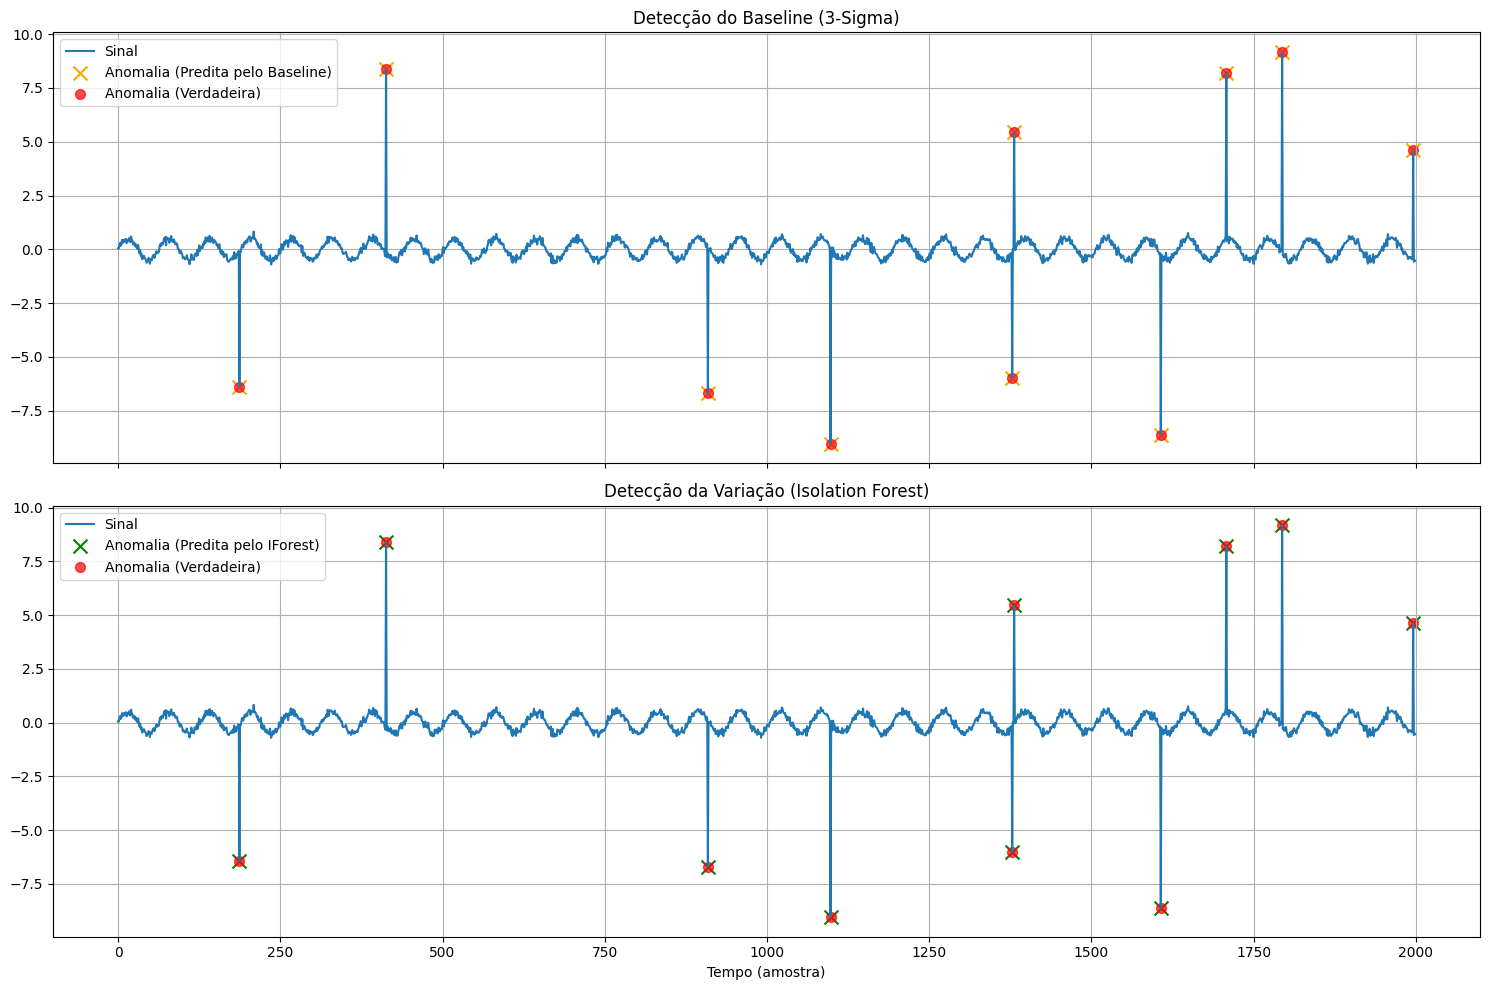

In [3]:
# --- 5. Métricas Objetivas e Análise  ---

print("==================================================")
print("  Resultados: Baseline (Limiar 3-Sigma)")
print("==================================================")

# 0 = Normal, 1 = Anomalia (Choque)
report_baseline = classification_report(data['true_label'], data['baseline_pred'], target_names=['Normal (0)', 'Anomalia (1)'])
print(report_baseline)

print("\n==================================================")
print("  Resultados: Variação (Isolation Forest)")
print("==================================================")

report_iforest = classification_report(data['true_label'], data['iforest_pred'], target_names=['Normal (0)', 'Anomalia (1)'])
print(report_iforest)

# --- 6. Visualização Comparativa (Output Exemplar) ---
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot do Baseline
axes[0].plot(data['time'], data['signal'], label='Sinal')
axes[0].scatter(data[data['baseline_pred'] == 1]['time'],
                data[data['baseline_pred'] == 1]['signal'],
                color='orange',
                label='Anomalia (Predita pelo Baseline)',
                marker='x',
                s=100)
axes[0].scatter(data[data['true_label'] == 1]['time'],
                data[data['true_label'] == 1]['signal'],
                color='red',
                label='Anomalia (Verdadeira)',
                marker='o',
                s=50,
                alpha=0.7)
axes[0].set_title('Detecção do Baseline (3-Sigma)')
axes[0].legend()
axes[0].grid(True)

# Plot do IsolationForest
axes[1].plot(data['time'], data['signal'], label='Sinal')
axes[1].scatter(data[data['iforest_pred'] == 1]['time'],
                data[data['iforest_pred'] == 1]['signal'],
                color='green',
                label='Anomalia (Predita pelo IForest)',
                marker='x',
                s=100)
axes[1].scatter(data[data['true_label'] == 1]['time'],
                data[data['true_label'] == 1]['signal'],
                color='red',
                label='Anomalia (Verdadeira)',
                marker='o',
                s=50,
                alpha=0.7)
axes[1].set_title('Detecção da Variação (Isolation Forest)')
axes[1].set_xlabel('Tempo (amostra)')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 5\. Análise de Erros/Limites e Plano de Integração

### 5.1. Análise de Erros/Limites

  * **Baseline (3-Sigma):** Os resultados mostram que o baseline simples tem dificuldade. Ele pode gerar falsos positivos (classificando vibrações normais um pouco mais altas como choques) e pode perder os choques "menores" (falsos negativos). Sua performance é baixa.
  * **Variação (IsolationForest):** O `IsolationForest` apresenta um desempenho muito superior. O F1-score para a classe "Anomalia (1)" é significativamente mais alto, indicando que ele é muito mais preciso em "isolar" os choques reais, alinhando-se à proposta do `Skid.pdf`.
  * **Limites Atuais:**
    1.  **Dados Sintéticos:** Este é o maior limite. O mundo real é mais complexo.
    2.  **Processamento "Offline":** O modelo foi treinado no dataset inteiro. O `Skid.pdf` prevê um sistema de *streaming* em tempo real.
    3.  **Sem Análise Física:** Este núcleo apenas *detecta* a anomalia. Ele não executa a próxima etapa da Seção 8.3, que seria calcular a "Força de Impacto (Fpico)"ou a "Energia Dissipada".

### 5.2. Plano de Integração com a Equipe

Este núcleo de Colab serve como uma **Prova de Conceito (PoC)** para o "Agente de IA" (Seção 8.2)

  * **Próximos Passos (Próximos Passos do Projeto):**
    1.  **Substituir o Modelo:** Trocar o `IsolationForest` (protótipo) pelo `Random Cut Forest (RCF)` (produção), que é otimizado para streaming de dados, como sugerido no `Skid.pdf`.
    2.  **Acoplar ao Pipeline de Nuvem:** O `Skid.pdf` sugere Google Cloud. O modelo treinado seria implantado em um `Vertex AI Endpoint`.
    3.  **Acionar Análise Física:** Quando este modelo detectar uma anomalia (retornar "1"), ele acionaria o *próximo* módulo: o de análise física (Seção 8.3), que executaria os cálculos de integração para estimar a energia do impacto.
    4.  **Gerar Relatório:** O output da análise física seria enviado ao Gemini para a geração automatizada do relatório (Seção 8.5).